# Visualize filters learned from finetuning our model

In [34]:
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import VGG16
from keras import backend as K

from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from confusion_matrix import plot_confusion_matrix
from plot_history import plot

from matplotlib import pyplot as plt

# dimensions of the generated pictures for each filter.
img_width = 256
img_height = 256

In [20]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv3'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def vgg():# build the VGG16 network
    model = VGG16(weights='imagenet', include_top=False, input_shape = (256,256,3))
    last = model.output

    x = Flatten(input_shape=model.output_shape[1:])(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(model.input, output)    
    return model

vgg_test_model = vgg()
vgg_test_model.load_weights('./weights/vgg16_finetune_cnn_14-0.97.hdf5')

# build the VGG16 network with ImageNet weights
model = vgg_test_model
print('Model loaded.')

Model loaded.


In [21]:
model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [22]:

kept_filters = []
for filter_index in range(0, 200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 0.0
Filter 0 processed in 1s
Processing filter 1
Current loss value: 0.0
Filter 1 processed in 1s
Processing filter 2
Current loss value: 0.0
Filter 2 processed in 1s
Processing filter 3
Current loss value: 0.0
Filter 3 processed in 1s
Processing filter 4
Current loss value: 0.000316015
Current loss value: 0.01692
Current loss value: 1.07223
Current loss value: 4.08112
Current loss value: 7.44979
Current loss value: 14.0774
Current loss value: 20.6809
Current loss value: 30.3977
Current loss value: 39.0699
Current loss value: 51.4728
Current loss value: 60.7148
Current loss value: 75.228
Current loss value: 90.0155
Current loss value: 103.167
Current loss value: 119.734
Current loss value: 133.242
Current loss value: 151.68
Current loss value: 167.296
Current loss value: 183.458
Current loss value: 198.769
Filter 4 processed in 1s
Processing filter 5
Current loss value: 0.0
Filter 5 processed in 1s
Processing filter 6
Current loss value: 0.0
Filt

Current loss value: 119.123
Current loss value: 134.694
Current loss value: 145.775
Current loss value: 164.804
Current loss value: 176.402
Filter 50 processed in 2s
Processing filter 51
Current loss value: 0.0461806
Current loss value: 0.64883
Current loss value: 2.12139
Current loss value: 3.97489
Current loss value: 8.31263
Current loss value: 12.626
Current loss value: 19.1894
Current loss value: 23.8325
Current loss value: 31.7474
Current loss value: 36.1238
Current loss value: 42.2387
Current loss value: 48.2341
Current loss value: 57.7344
Current loss value: 65.8947
Current loss value: 75.6176
Current loss value: 82.9133
Current loss value: 93.0742
Current loss value: 100.59
Current loss value: 109.432
Current loss value: 119.289
Filter 51 processed in 2s
Processing filter 52
Current loss value: 0.0
Filter 52 processed in 1s
Processing filter 53
Current loss value: 0.0
Filter 53 processed in 1s
Processing filter 54
Current loss value: 0.0
Filter 54 processed in 1s
Processing fil

Current loss value: 7.73172
Current loss value: 12.9588
Current loss value: 19.4061
Current loss value: 26.8309
Current loss value: 33.1341
Current loss value: 41.724
Current loss value: 51.982
Current loss value: 61.834
Current loss value: 73.1034
Current loss value: 85.0124
Current loss value: 96.5592
Current loss value: 109.846
Current loss value: 123.814
Current loss value: 140.118
Current loss value: 155.363
Filter 110 processed in 2s
Processing filter 111
Current loss value: 0.0
Filter 111 processed in 1s
Processing filter 112
Current loss value: 0.0
Filter 112 processed in 1s
Processing filter 113
Current loss value: 0.0
Filter 113 processed in 1s
Processing filter 114
Current loss value: 0.0
Filter 114 processed in 1s
Processing filter 115
Current loss value: 0.0
Filter 115 processed in 1s
Processing filter 116
Current loss value: 0.00036329
Current loss value: 0.310967
Current loss value: 1.21764
Current loss value: 1.94684
Current loss value: 4.80267
Current loss value: 7.465

Current loss value: 54.7646
Current loss value: 63.2242
Current loss value: 70.0584
Current loss value: 76.5514
Current loss value: 83.1294
Current loss value: 90.6916
Current loss value: 96.6528
Current loss value: 102.66
Current loss value: 109.385
Current loss value: 116.084
Filter 155 processed in 2s
Processing filter 156
Current loss value: 0.0
Filter 156 processed in 2s
Processing filter 157
Current loss value: 0.0
Filter 157 processed in 1s
Processing filter 158
Current loss value: 0.0
Filter 158 processed in 1s
Processing filter 159
Current loss value: 0.0
Filter 159 processed in 1s
Processing filter 160
Current loss value: 0.0
Filter 160 processed in 2s
Processing filter 161
Current loss value: 0.0
Filter 161 processed in 2s
Processing filter 162
Current loss value: 0.0
Filter 162 processed in 1s
Processing filter 163
Current loss value: 0.0
Filter 163 processed in 1s
Processing filter 164
Current loss value: 0.0
Filter 164 processed in 1s
Processing filter 165
Current loss va

In [28]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 4

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [29]:
len(kept_filters)

16

In [30]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('./ballerina_stitched_filters_%dx%d.png' % (n, n), stitched_filters)


In [33]:
stitched_filters.shape

(1039, 1039, 3)

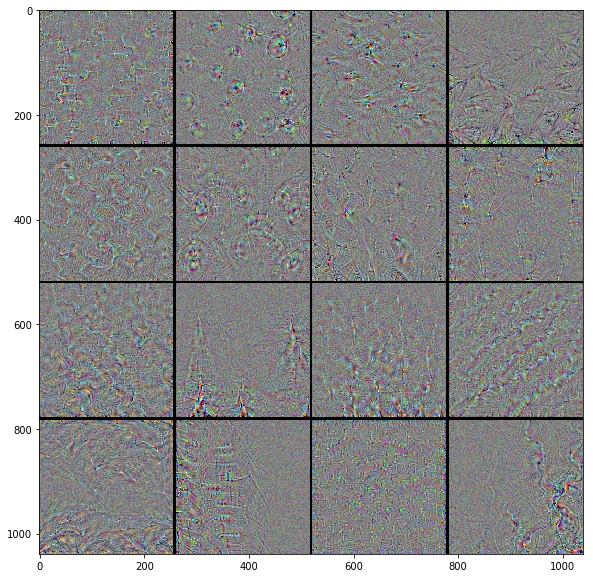

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(stitched_filters)
plt.show()

Filters are very different from original VGG16 trained on Imagenet, but unfortunately not interpretable. Maybee we need to finetune for more time, or use regularization